In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange
import skimage
from skimage import io

# Data obtained from sensors

We have 10 datasets:
1. 989.09 meters &nbsp; &nbsp; | &nbsp; 21 defects &nbsp; | &nbsp; 116 welds &nbsp; | &nbsp; 1 or 2 sections don't work
2. 2705.02 meters &nbsp; | &nbsp; 7 defects &nbsp; &nbsp; | &nbsp; 276 welds &nbsp; | &nbsp; 1 or 2 sections don't work
3. 7890.75 meters &nbsp; | &nbsp; 15 defects &nbsp; | &nbsp; 819 welds &nbsp; | &nbsp; small sensors issues
4. 2743.74 meters &nbsp; | &nbsp; 39 defects &nbsp; | &nbsp; 269 welds &nbsp; | &nbsp; 1 section doesn't work
5. 15162.85 meters&nbsp;|&nbsp; 745 defects &nbsp;|&nbsp; 1462 welds &nbsp;| &nbsp; 2 or 3 sections don't work
6. 752.80 meters &nbsp; &nbsp; | &nbsp; 1 defect &nbsp; &nbsp; &nbsp; | &nbsp; 111 welds &nbsp; | &nbsp; 1 section doesn't work
7. 1786.21 meters &nbsp; | &nbsp; 12 defects &nbsp; | &nbsp; 219 welds &nbsp; | &nbsp; 1, 2 or 3 sections don't work
8. 4528.35 meters &nbsp; | &nbsp; 15 defects &nbsp; | &nbsp; 431 welds &nbsp; | &nbsp; small sensors issues
9. 982.56 meters &nbsp; &nbsp; | &nbsp; 15 defects &nbsp; | &nbsp; 107 welds &nbsp; | &nbsp; no issues
10. 18883.02 meters&nbsp;| &nbsp; 72 defects &nbsp; |&nbsp; 1708 welds &nbsp;| &nbsp; small sensors issues

For the research we selected 5th dataset because of the defects amount.

Let us upload it:

In [2]:
df = pd.read_csv('../../data/raw_data/mag_5/magnetogram.csv')

In [3]:
df.head(3)

,Tag,Size,Time,Dist,Wheel1_v,Wheel2_v,Index,Angle,Flags,Dist_ext,...,15.1,15.2,15.3,15.4,Status 16,16.1,16.2,16.3,16.4,CRC
0,VDF0,112,38.481254,-3075,3399,1367,0,0,6b,0,...,0,0,35,0,0,0,0,0,0,40536e88
1,VDF0,112,52.869986,-2743,3474,1348,1,0,2b,0,...,68,153,218,258,0,0,0,0,0,a6493a3d
2,VDF0,112,54.780140,-3078,3513,1273,2,0,4b,0,...,79,32,44,56,0,0,0,0,0,c6a4697f


We use preprocessing for selecting important columns, distance correcting, etc.

In [4]:
from preproc import get_df
df = get_df(df)

Finally, dataset looks like this:

In [5]:
df.head(3)

,1.1,1.2,1.3,1.4,2.1,2.2,2.3,2.4,3.1,3.2,...,14.3,14.4,15.1,15.2,15.3,15.4,16.1,16.2,16.3,16.4
7.67144,3171,3180,3174,3164,3172,3178,3188,3199,0,0,...,3200,3193,3207,3195,3195,3173,3187,3189,3206,3183
7.67484,3172,3180,3177,3166,3170,3179,3189,3200,0,0,...,3200,3194,3206,3195,3196,3173,3186,3188,3202,3183
7.67819,3171,3176,3177,3165,3172,3176,3190,3199,0,0,...,3200,3189,3206,3194,3198,3175,3186,3191,3201,3182


Let us look at the data in appropriate way.

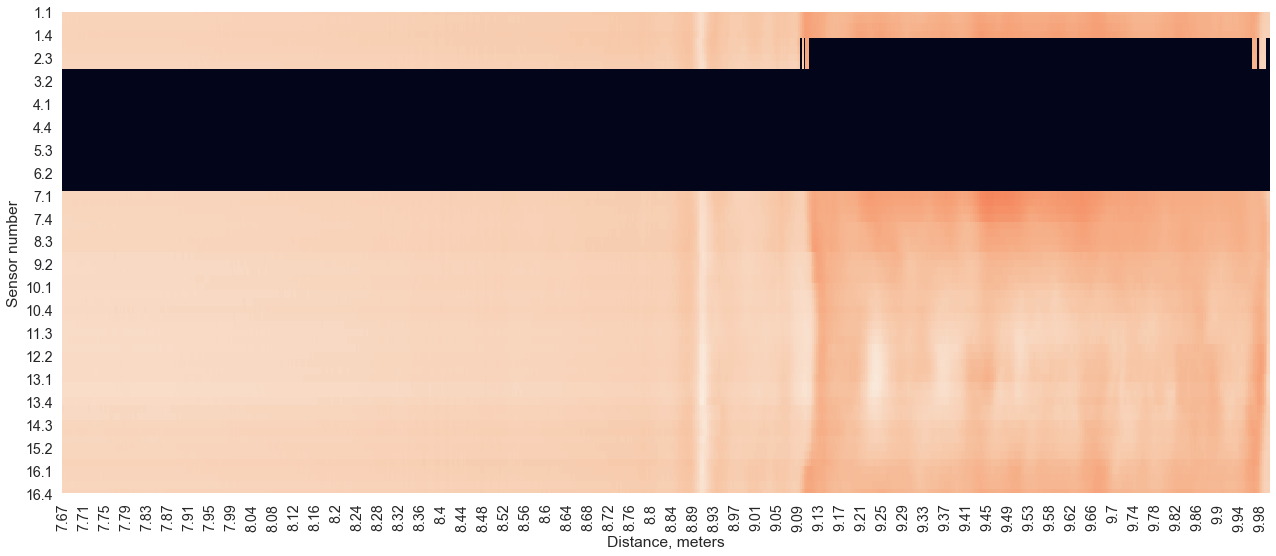

In [6]:
df_to_plot = df[:10]
df_to_plot.index = np.round(df_to_plot.index, 2)
num_of_labels = int(df_to_plot.shape[1]/5)

sns.set(rc={'figure.figsize':(18,8)})
sns.set(font_scale=1.3)
sns_plot = sns.heatmap(df_to_plot.T, cbar=False, xticklabels=num_of_labels)
plt.xlabel('Distance, meters')
plt.ylabel('Sensor number')
plt.tight_layout()
plt.show()

# Defects

Let us upload defects file.

In [7]:
defects = pd.read_csv('../../data/defects/defects_5.csv', index_col='Unnamed: 0')

In [8]:
defects.rename(columns={
    '№ дефекта':'№ of the defect',
    'Дистанция, м':'Distance, m',
    'Дистанция от начала секции до максимума сигнала, м':'Distance from the section beginning to the signal max, m',
    '№ секции':'№ of the section',
    'Тип дефекта':'Defect type',
    'Глубина, %':'Defect depth, %',
    'Размер зоны индикации LxB, мм':'Indication zone size LxB, mm',
    'Толщина стенки, мм':'Wall thickness, mm',
    'Местоположение дефекта':'Defect location',
    'Номер магнито-граммы':'№ of the magnitogramm',
}, inplace=True)

In [9]:
defects.head(3)

,№ of the defect,"Distance, m","Distance from the section beginning to the signal max, m",№ of the section,Defect type,"Defect depth, %","Размер зоны индикации BxL, мм","Wall thickness, mm",Defect location,№ of the magnitogramm
0,1,168.36,0.00,26,Коррозия шва,NaN,15x150,8.0,Сварной шов,NaN
1,2,373.90,0.00,45,Коррозия шва,NaN,10х70,7.7,Сварной шов,NaN
2,3,566.62,3.24,62,Коррозионная риска,35.0,10х40,7.5,Стенка трубы,NaN


There are different defect types:

In [10]:
defects['Defect type'].value_counts()

Питтинг                        185
Общая коррозия (скопление)     169
Коррозионная канавка           108
Язвенная коррозия              104
Скопление питтингов             80
Коррозия шва                    35
Скопление язвенных коррозий     30
Коррозионная риска              29
Питтинг                          3
Общая коррозия (скопление)       1
Коррозионная риска               1
Name: Defect type, dtype: int64

For now we do not separate defects classes, we count all of them as class 'defect'.

There are different defect locations:

In [11]:
defects['Defect location'].value_counts()

Стенка трубы    711
Сварной шов      34
Name: Defect location, dtype: int64

We choose the defects located on the pipe wall (in Russion 'Стенка трубы').

In [12]:
from preproc import crop_squares_with_defects

In [13]:
pictures_with_defects = crop_squares_with_defects(df, defects[defects['Defect location'] =='Стенка трубы'])

In [14]:
print(f'Total number of pictures with defects is equal to {len(pictures_with_defects)}')

Total number of pictures with defects is equal to 711


Here is a sample with defect.

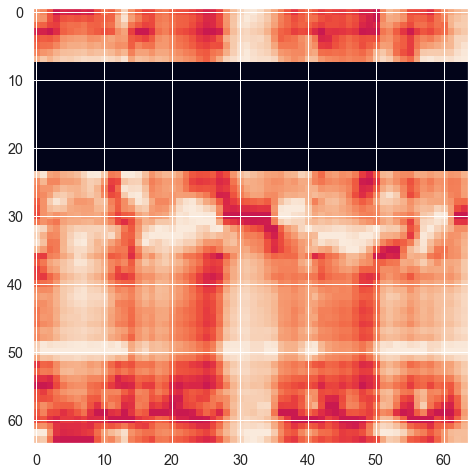

In [138]:
plt.imshow(pictures_with_defects[35])
plt.show()

# Welds

Let us upload journal file.

In [15]:
journal = pd.read_excel('../../data/journals/journal_5.xlsx')

In [16]:
journal.rename(columns={
    '№ секции':'№ of the section',
    'Местоположение начала секции по дистанции трубопровода, м':'Location of the section beginning, m',
    'Длина секции, м':'Section length, m',
    'Номина-льная толщина стенки, мм':'Nominal wall thickness, mm',
    'Средняя толщина стенки, мм':'Mean wall thickness, mm',
    'Внешний диаметр трубы, мм':'Outside pipe diameter, mm',
    'Тип секции':'Section type',
}, inplace=True)

In [17]:
journal = journal[(journal['Location of the section beginning, m'] > df.index[0]) &
                 (journal['Location of the section beginning, m'] < df.index[-1])]

In [18]:
journal.head(3)

,№ of the section,"Location of the section beginning, m","Section length, m","Nominal wall thickness, mm","Mean wall thickness, mm","Outside pipe diameter, mm",Section type
9,10,8.90,1.30,8.0,NaN,219.0,отвод
10,11,10.21,8.43,8.0,8.4,219.0,бесшовная
11,12,18.64,11.83,8.0,8.4,219.0,бесшовная


Let us check the variety of section types.

In [19]:
journal['Section type'].value_counts()

бесшовная      860
прямошовная    570
отвод           15
задвижка         1
Name: Section type, dtype: int64

In [20]:
from preproc import crop_squares_with_welds

In [21]:
pictures_with_normal_welds, pictures_with_defected_welds = crop_squares_with_welds(df, journal, defects)

In [22]:
print(f'Total number of pictures with welds without defects is equal to {len(pictures_with_normal_welds)}')
print(f'Total number of pictures with defected welds is equal to {len(pictures_with_defected_welds)}')

Total number of pictures with welds without defects is equal to 34
Total number of pictures with defected welds is equal to 1412


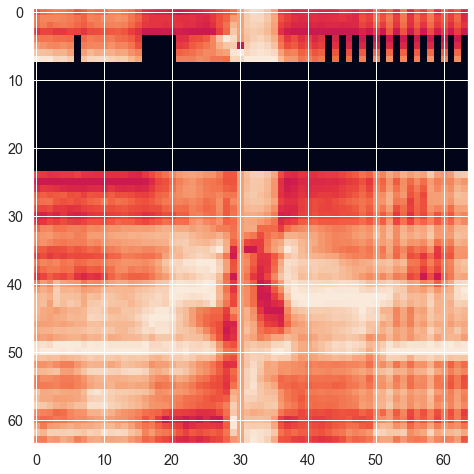

In [139]:
plt.imshow(pictures_with_normal_welds[5])
plt.show()

# Normal data

In [23]:
journal = journal[(journal['Section type']=='бесшовная') |
                  (journal['Section type']=='прямошовная')]

In [24]:
from preproc import crop_squares_with_normal

In [25]:
normal_pictures = crop_squares_with_normal(df, journal, defects)

In [26]:
print(f'Total number of pictures with without any defects or welds is equal to {len(normal_pictures)}')

Total number of pictures with without any defects or welds is equal to 11690


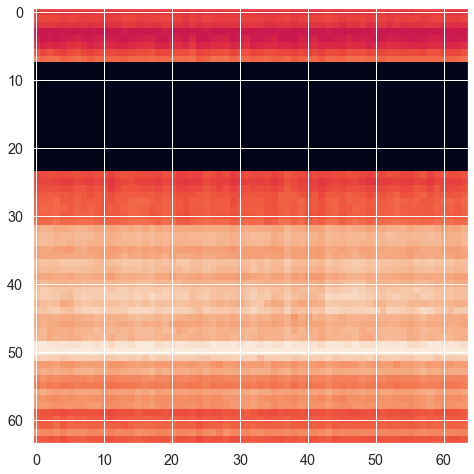

In [140]:
plt.imshow(normal_pictures[3])
plt.show()

# Pictures saving

In [128]:
from preproc import train_test_saving

In [135]:
train_test_saving(normal_pictures, kind='normal')

/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [136]:
train_test_saving(pictures_with_normal_welds, kind='normal_weld')

In [137]:
train_test_saving(pictures_with_defects, kind='defect')